In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import interpolation
import disambiguation_analysis as da

### Get Data

In [2]:
census_filled_file = "../data/dwelling_filled_sum_1850_mn_v01.csv"

In [3]:
census = pd.read_csv("../data/census_1850_indexUpdate.csv")
disambiguation = pd.read_csv("../data/1850_disambiguated.csv")
city_directory = pd.read_csv("../data/cd_1850_XYupdate.csv")

### Initial disambiguation

In [4]:
census_disamb = da.add_disamb_census(disambiguation, census)

In [5]:
print("City directory match rate:", disambiguation["selected"].sum()/len(city_directory))
print("Census record match rate:", da.get_match_rate(census_disamb))

City directory match rate: 0.38776535611104135
Census record match rate: 0.023947404146384035


In [6]:
print("Census record match rate broken down by ward")
da.get_ward_match(census_disamb)

Census record match rate broken down by ward
Ward  1 :  0.03072
Ward  2 :  0.02329
Ward  3 :  0.01516
Ward  4 :  0.02417
Ward  5 :  0.03491
Ward  6 :  0.01737
Ward  7 :  0.03071
Ward  8 :  0.03522
Ward  9 :  0.03911
Ward  10 :  0.02385
Ward  11 :  0.01006
Ward  12 :  0.0
Ward  13 :  0.03558
Ward  14 :  0.02957
Ward  15 :  0.02291
Ward  16 :  0.0277
Ward  17 :  0.01691
Ward  18 :  0.01141
Ward  19 :  0.00016


### Disambiguation dwelling conflicts and resolution analysis

In [7]:
ward_column = "CENSUS_WARD_NUM"
dwelling_column = "CENSUS_DWELLING_NUM"
total_num_dwellings = census_disamb.groupby([ward_column, dwelling_column]).ngroups

In [8]:
conflicts_info = da.get_counts(census_disamb)

In [9]:
print("Proportion of dwelling records with single address match:", round(sum(conflicts_info["single_address"][0].values())/total_num_dwellings, 5))
print("Proportion of dwelling records with multiple address matches:",round(sum(conflicts_info["multiple_addresses"][0].values())/total_num_dwellings, 5))
print("Proportion of dwelling records without any match:", round(sum(conflicts_info["no_address"][0].values())/total_num_dwellings, 5))
print("Proportion of dwellings with address after resolving conflicts:", round((sum(conflicts_info["single_address"][0].values()) + sum(conflicts_info["multiple_addresses"][0].values()))/total_num_dwellings, 5))

Proportion of dwelling records with single address match: 0.24752
Proportion of dwelling records with multiple address matches: 0.13201
Proportion of dwelling records without any match: 0.62048
Proportion of dwellings with address after resolving conflicts: 0.37952


In [10]:
print("Proportion of census records with single address match:", round(conflicts_info["single_address"][1]/len(census_disamb), 5))
print("Proportion of census records with multiple address matches:",round(conflicts_info["multiple_addresses"][1]/len(census_disamb), 5))
print("Proportion of census records without any match:", round(conflicts_info["no_address"][1]/len(census_disamb), 5))
print("Proportion of census records with address after resolving conflicts:", round((conflicts_info["single_address"][1] + conflicts_info["multiple_addresses"][1])/len(census_disamb), 5))

Proportion of census records with single address match: 0.29482
Proportion of census records with multiple address matches: 0.21219
Proportion of census records without any match: 0.49123
Proportion of census records with address after resolving conflicts: 0.50701


In [11]:
ward_dwelling_conflict_info = pd.DataFrame([x[0] for x in conflicts_info.values()], index=[key for key in conflicts_info]).T
ward_dwelling_conflict_info.fillna(0, inplace = True)
ward_dwelling_conflict_info = ward_dwelling_conflict_info.transform(lambda x: x / x.sum(), axis = 1)
ward_dwelling_conflict_info["with_address"] = ward_dwelling_conflict_info["single_address"] + ward_dwelling_conflict_info["multiple_addresses"]

In [12]:
print("Ward break down of dwelling proportions")
display(ward_dwelling_conflict_info)

Ward break down of dwelling proportions


,no_address,single_address,multiple_addresses,with_address
1,0.476603,0.275563,0.247834,0.523397
2,0.752358,0.174528,0.073113,0.247642
3,0.813510,0.157122,0.029369,0.186490
4,0.546053,0.297368,0.156579,0.453947
5,0.506770,0.346228,0.147002,0.493230
6,0.575246,0.319269,0.105485,0.424754
7,0.481918,0.328848,0.189235,0.518082
8,0.380465,0.333023,0.286512,0.619535
9,0.391922,0.318624,0.289454,0.608078
10,0.636888,0.268972,0.094140,0.363112


In [13]:
#Resolve dwelling conflicts
census_filled = census_disamb.groupby([ward_column, dwelling_column]).apply(da.dwelling_weight_fill)
#Add in values dropped because they don't have a dwelling number
census_filled = pd.concat([census_filled, census_disamb[census_disamb[dwelling_column].isnull()]], sort= True)
census_filled.to_csv(census_filled_file)

In [14]:
census_filled_dwellings = census_filled.groupby([ward_column, dwelling_column], as_index = False).first()

In [15]:
print("Census record match rate:", da.get_match_rate(census_filled))
print("Dwelling record match rate:", da.get_match_rate(census_filled_dwellings))

Census record match rate: 0.5070690223609953
Dwelling record match rate: 0.37952080706179064


### Block number analysis

In [16]:
blocks = [{}, {}, {}]
for ward in city_directory["Ward_Num"].dropna().unique():
    cd = city_directory[city_directory["Ward_Num"] == ward]
    cens = census_filled_dwellings[census_filled_dwellings[ward_column] == ward]
    
    blocks[0][ward] = cens.BLOCK_NUM.nunique()
    blocks[1][ward] = cd.block_num.nunique()
    blocks[2][ward] = round(blocks[0][ward]/blocks[1][ward], 5)

In [17]:
blocks_info = pd.DataFrame(blocks, index=["census blocks", "cd blocks", "proportion of census blocks in cd"]).T.sort_index()
display(blocks_info)

,census blocks,cd blocks,proportion of census blocks in cd
1.0,68.0,82.0,0.82927
2.0,37.0,49.0,0.75510
3.0,38.0,43.0,0.88372
4.0,45.0,49.0,0.91837
5.0,74.0,76.0,0.97368
6.0,42.0,45.0,0.93333
7.0,71.0,72.0,0.98611
8.0,61.0,63.0,0.96825
9.0,103.0,112.0,0.91964
10.0,45.0,45.0,1.00000


### Engineered sequence analysis

In [18]:
block_column = "BLOCK_NUM"

In [19]:
dwellings_dropped = census_filled_dwellings.dropna(subset = [block_column])
dwellings_dropped = dwellings_dropped.groupby(ward_column, as_index = False).apply(interpolation.col_for_seq)
dwellings_dropped.dropna(subset = ["dist"], inplace = True)

In [20]:
#Select maximum possible distance between consecutive known addresses
#Based on two options, number of 
options = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
min_len = [1]
sequence_tuning = interpolation.tune_sequence_dist(dwellings_dropped, options, min_len)
print("Selected maximum distance between consecutive dwellings:", sequence_tuning["dist"])
dwellings_sequence = sequence_tuning["df"]

Selected maximum distance between consecutive dwellings: 0.25


In [21]:
#Add back in dropped rows
all_dwellings_graph = interpolation.dwellings_to_all(census_filled_dwellings, dwellings_sequence, list(set(list(dwellings_sequence.columns)).difference(list(census_filled_dwellings.columns))) + [ward_column, dwelling_column], [ward_column, dwelling_column])
sequence_graph_df = all_dwellings_graph.dropna(subset = ["CD_X"]).copy()
sequence_graph_df["sequence_id"] = sequence_graph_df["sequence_id"].ffill()

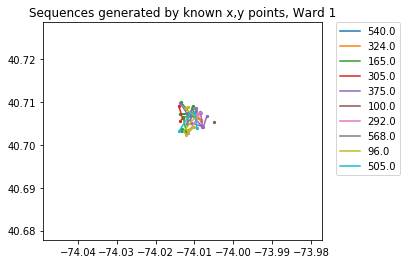

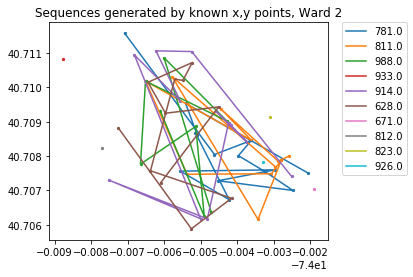

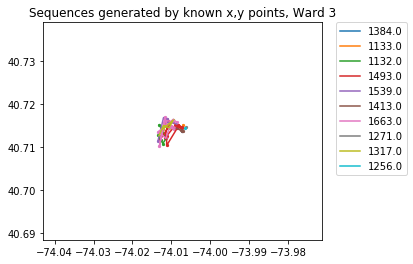

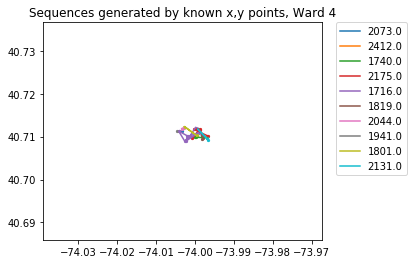

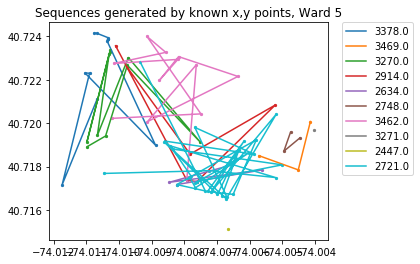

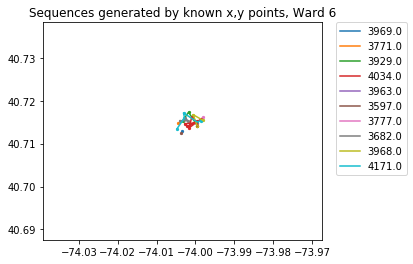

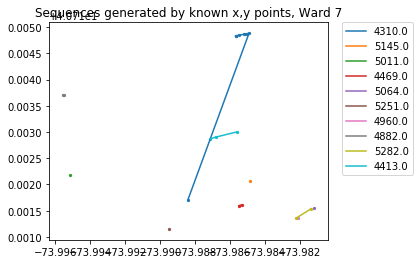

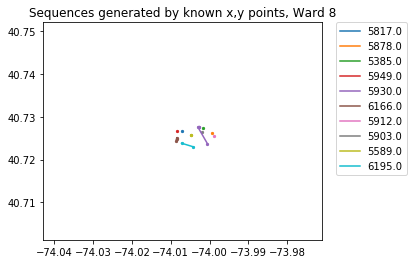

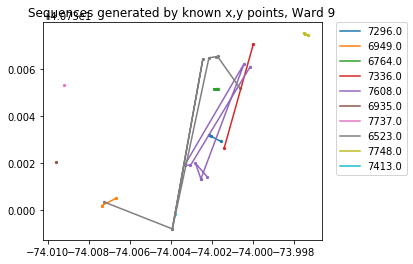

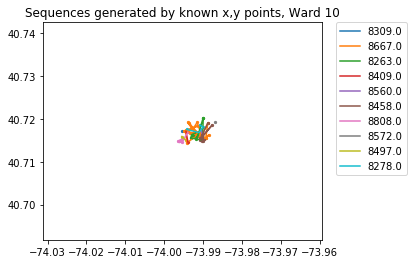

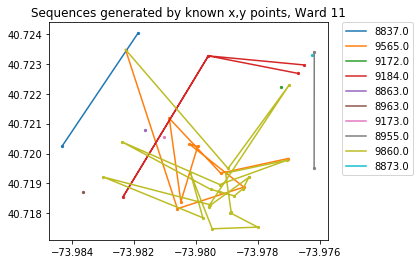

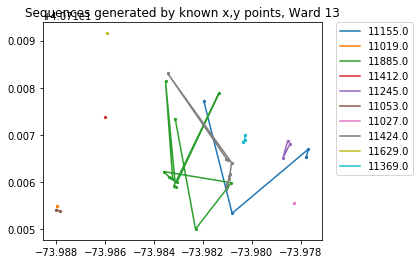

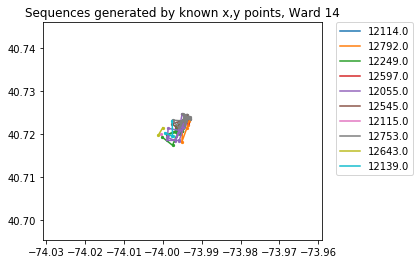

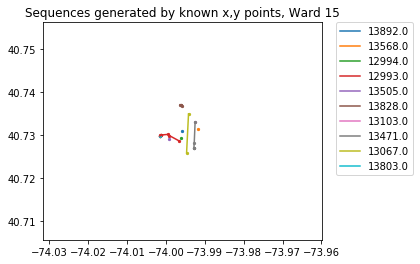

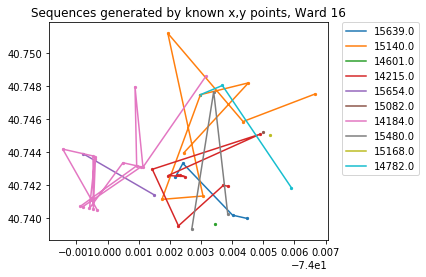

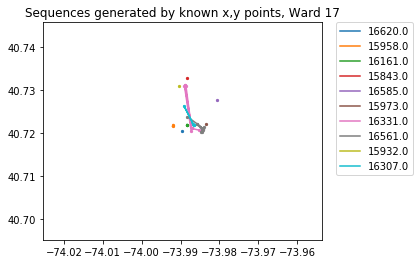

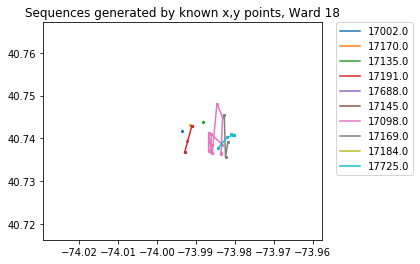

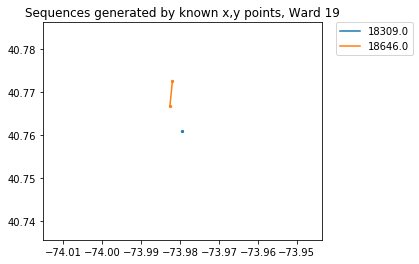

In [33]:
for ward in sequence_graph_df[ward_column].unique():
    fig,ax = plt.subplots(1,1, figsize = (5,4))
    dwellings_w = sequence_graph_df[sequence_graph_df[ward_column] == ward]
    
    if dwellings_w["sequence_id"].nunique() <= 10:
        sequences = dwellings_w["sequence_id"].unique()
    else:
        sequences = np.random.choice(dwellings_w["sequence_id"].unique(), 10, replace = False)
    
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(sequences))]
    
    for sequence, color in zip(sequences, colors):
        dwelling_seq = dwellings_w[dwellings_w["sequence_id"] == sequence]
        ax.plot(dwelling_seq["CD_X"], dwelling_seq["CD_Y"], label = sequence, color = color)
        ax.scatter(dwelling_seq["CD_X"], dwelling_seq["CD_Y"], s = 5, color = color)
    ax.set_title("Sequences generated by known x,y points, Ward "+str(ward))
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Interpolation Between Known Addresses

In [39]:
dwelling_sequence_sames = interpolation.same_next(dwellings_sequence)
all_dwellings = interpolation.all_dwellings_sequenced(census_filled_dwellings, dwelling_sequence_sames)
interpolate_dwellings = interpolation.get_consecutive_dwellings(all_dwellings)

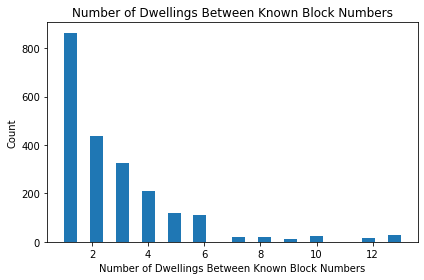

In [43]:
plt.hist(interpolate_dwellings["num_between_real"], bins = "auto")
plt.xlabel("Number of Dwellings Between Known Block Numbers")
plt.ylabel("Count")
plt.title("Number of Dwellings Between Known Block Numbers")
plt.tight_layout()
plt.show()

In [55]:
num_between = [5,10,25,40]
for num in num_between:
    
    to_interpolate = interpolation.limit_dwellings_between(interpolate_dwellings,num)
    total_interpolate = to_interpolate["CD_ADDRESS"].isnull().sum()
    print("Maximum of {} dwellings between".format(str(num)))
    display(to_interpolate.loc[:,[ward_column, dwelling_column, block_column, "CD_ADDRESS", "CD_X", "CD_Y", "num_between", "sequence_id"]].head(10))
    print("Number of dwellings that would be assigned a block:", total_interpolate)
    print("Proportion increase dwellings assigned a block:", round(total_interpolate/total_num_dwellings, 5), "\n")

Maximum of 5 dwellings between


,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,num_between,sequence_id
226,1.0,227.0,649.0,34 More,-74.013324,40.702469,2.0,231.0
227,1.0,228.0,NaN,NaN,NaN,NaN,NaN,231.0
228,1.0,229.0,649.0,& Co,-74.014310,40.703419,NaN,231.0
274,1.0,275.0,676.0,139 Washington,-74.013697,40.709763,2.0,277.0
275,1.0,276.0,NaN,NaN,NaN,NaN,NaN,277.0
276,1.0,277.0,676.0,137 Washington,-74.013728,40.709692,NaN,277.0
398,1.0,399.0,7.0,36 Trinity pl,-74.012578,40.708230,3.0,402.0
399,1.0,400.0,NaN,NaN,NaN,NaN,NaN,402.0
400,1.0,401.0,NaN,NaN,NaN,NaN,NaN,402.0
401,1.0,402.0,7.0,40 Trinity pl,-74.012659,40.708114,NaN,402.0


Number of dwellings that would be assigned a block: 926
Proportion increase dwellings assigned a block: 0.04671 

Maximum of 10 dwellings between


,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,num_between,sequence_id
226,1.0,227.0,649.0,34 More,-74.013324,40.702469,2.0,231.0
227,1.0,228.0,NaN,NaN,NaN,NaN,NaN,231.0
228,1.0,229.0,649.0,& Co,-74.014310,40.703419,NaN,231.0
274,1.0,275.0,676.0,139 Washington,-74.013697,40.709763,2.0,277.0
275,1.0,276.0,NaN,NaN,NaN,NaN,NaN,277.0
276,1.0,277.0,676.0,137 Washington,-74.013728,40.709692,NaN,277.0
398,1.0,399.0,7.0,36 Trinity pl,-74.012578,40.708230,3.0,402.0
399,1.0,400.0,NaN,NaN,NaN,NaN,NaN,402.0
400,1.0,401.0,NaN,NaN,NaN,NaN,NaN,402.0
401,1.0,402.0,7.0,40 Trinity pl,-74.012659,40.708114,NaN,402.0


Number of dwellings that would be assigned a block: 1069
Proportion increase dwellings assigned a block: 0.05392 

Maximum of 25 dwellings between


,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,num_between,sequence_id
226,1.0,227.0,649.0,34 More,-74.013324,40.702469,2.0,231.0
227,1.0,228.0,NaN,NaN,NaN,NaN,NaN,231.0
228,1.0,229.0,649.0,& Co,-74.014310,40.703419,NaN,231.0
274,1.0,275.0,676.0,139 Washington,-74.013697,40.709763,2.0,277.0
275,1.0,276.0,NaN,NaN,NaN,NaN,NaN,277.0
276,1.0,277.0,676.0,137 Washington,-74.013728,40.709692,NaN,277.0
398,1.0,399.0,7.0,36 Trinity pl,-74.012578,40.708230,3.0,402.0
399,1.0,400.0,NaN,NaN,NaN,NaN,NaN,402.0
400,1.0,401.0,NaN,NaN,NaN,NaN,NaN,402.0
401,1.0,402.0,7.0,40 Trinity pl,-74.012659,40.708114,NaN,402.0


Number of dwellings that would be assigned a block: 1107
Proportion increase dwellings assigned a block: 0.05584 

Maximum of 40 dwellings between


,CENSUS_WARD_NUM,CENSUS_DWELLING_NUM,BLOCK_NUM,CD_ADDRESS,CD_X,CD_Y,num_between,sequence_id
226,1.0,227.0,649.0,34 More,-74.013324,40.702469,2.0,231.0
227,1.0,228.0,NaN,NaN,NaN,NaN,NaN,231.0
228,1.0,229.0,649.0,& Co,-74.014310,40.703419,NaN,231.0
274,1.0,275.0,676.0,139 Washington,-74.013697,40.709763,2.0,277.0
275,1.0,276.0,NaN,NaN,NaN,NaN,NaN,277.0
276,1.0,277.0,676.0,137 Washington,-74.013728,40.709692,NaN,277.0
398,1.0,399.0,7.0,36 Trinity pl,-74.012578,40.708230,3.0,402.0
399,1.0,400.0,NaN,NaN,NaN,NaN,NaN,402.0
400,1.0,401.0,NaN,NaN,NaN,NaN,NaN,402.0
401,1.0,402.0,7.0,40 Trinity pl,-74.012659,40.708114,NaN,402.0


Number of dwellings that would be assigned a block: 1107
Proportion increase dwellings assigned a block: 0.05584 

